In [382]:
with open("requirements.txt", "r") as config_file:
    config_code = config_file.read()
    exec(config_code)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [383]:
tidy_finance = sqlite3.connect(database="data/specialedata.sqlite")

macro_predictors = (pd.read_sql_query(
    sql="SELECT * FROM macro_predictors",
    con=tidy_finance,
    parse_dates={"month"})
 .add_prefix("macro_")
)

JKPFactors = (pd.read_sql_query(
  sql="SELECT * FROM JKPFactors",
  con=tidy_finance,
  parse_dates={"month"})
  .add_prefix("jkp_factor_")
)
JKPFactornames = JKPFactors.columns

factors_ff3_monthly = (pd.read_sql_query(
     sql="SELECT * FROM factors_ff3_monthly",
     con=tidy_finance,
     parse_dates={"month"})
  .add_prefix("factor_ff3_")
)

factors_ff5_monthly = (pd.read_sql_query(
     sql="SELECT * FROM factors_ff5_monthly",
     con=tidy_finance,
     parse_dates={"month"})
  .add_prefix("factor_ff5_")
)

crsp_1000 = (pd.read_sql_query(
    sql="SELECT * FROM crsp_1000",
    con=tidy_finance,
    parse_dates={"month"})
)
crsp_500 = (pd.read_sql_query(
    sql="SELECT * FROM crsp_500",
    con=tidy_finance,
    parse_dates={"month"})
)
crsp_250 = (pd.read_sql_query(
    sql="SELECT * FROM crsp_250",
    con=tidy_finance,
    parse_dates={"month"})
)

crsp_100 = (pd.read_sql_query(
    sql="SELECT * FROM crsp_100",
    con=tidy_finance,
    parse_dates={"month"})
)

crsp_50 = (pd.read_sql_query(
    sql="SELECT * FROM crsp_50",
    con=tidy_finance,
    parse_dates={"month"})
)

# Select amount of tickers in cross section!
data_total = (crsp_50
        .merge(factors_ff5_monthly,
               how = "left", left_on = "month", right_on = "factor_ff5_month")
        .assign(ret_excess=lambda x: x["ret"] - x["factor_ff5_rf"]) 
        .drop(columns=['ret', 'factor_ff5_month'])
        .dropna()
       )

# Make a dataframe for stock characteristics and factors
macro_variables = data_total.filter(like="macro").columns
factor_variables = data_total.filter(like="jkp_factor").columns
macro_factors = data_total[macro_variables]
factors = data_total[macro_variables].merge(data_total[factor_variables], left_index=True, right_index=True)
char = data_total[['mktcap', 'mktcap_lag_1', 'mktcap_lag_3', 'mktcap_lag_6', 'mktcap_lag_12', 'mom_1', 'mom_3','mom_6', 'mom_12']]
# List of tickers
tickers = data_total['ticker'].unique()

# Transform data
column_combinations = list(product(macro_factors, char)) 

new_column_values = []
for macro_column, char in column_combinations:
    new_column_values.append(data_total[macro_column] * data_total[char])

column_names = [" x ".join(t) for t in column_combinations]
new_columns = pd.DataFrame(dict(zip(column_names, new_column_values)))

# New data set with added combinations
data = pd.concat([data_total, new_columns], axis=1)

preprocessor = ColumnTransformer(
  transformers=[
    ("scale", StandardScaler(), 
    [col for col in data.columns 
      if col not in ["ret_excess", "month", "ticker"]])
  ],
  remainder="drop",
  verbose_feature_names_out=False
)

training_date = "2017-07-01"

In [384]:
# FF 5 factor model
data_ff5 = data[['month','ticker','ret_excess','factor_ff5_mkt_excess','factor_ff5_smb','factor_ff5_hml','factor_ff5_rmw','factor_ff5_cma']]
colnames = ['month','ticker','ret_excess','mkt_excess','smb','hml','rmw','cma']
data_ff5.columns=colnames
# FF 3 factor model
data_ff3 = data_ff5.iloc[:,:6]
# ff3
data_capm = data_ff3.iloc[:,:4]

In [37]:
def data_prep(data):
    data_training = data.query(f"month<'{training_date}'")
    # Perform OLS regression
    X = sm.add_constant(data_training.drop(['ret_excess', 'month','ticker'], axis=1))
    y = np.array(data_training.loc[:,'ret_excess']).reshape(-1,1)
    model = sm.OLS(y, X).fit()
        
    # Predict on the entire dataset
    data['Fitted value'] = model.predict(sm.add_constant(data.drop(['ret_excess', 'month','ticker'], axis=1)))
    
    # Prepare data for plotting
    predicted_values = pd.DataFrame({
        "Fitted value": data['Fitted value'],
        "Realization": data['ret_excess']
    }).assign(month=data["month"]).melt(id_vars="month", var_name="Variable", value_name="return")
    
    # Predict on testing sample
    data_testing = data.iloc[:,:-1].query(f"month>='{training_date}'")
    X_test = sm.add_constant(data_testing.drop(['ret_excess', 'month','ticker'], axis=1))
    y_test = data_testing.loc[:,'ret_excess']
    data_testing['Fitted value'] = model.predict(X_test)
    
    # Evaluation metrics
    r2_pols = r2_score(y_test, data_testing['Fitted value'])
    mspe_pols = mean_squared_error(y_test, data_testing['Fitted value'])
    
    print(f'POLS out-of-sample R-squared: {round(r2_pols,4)}')
    print(f'POLS MSPE: {round(mspe_pols,4)}')
    return predicted_values

In [7]:
predicted_values_capm = data_prep(data_capm)
predicted_values_ff3 = data_prep(data_ff3)
predicted_values_ff5 = data_prep(data_ff5)

POLS out-of-sample R-squared: 0.2065
POLS MSPE: 0.0116
POLS out-of-sample R-squared: 0.2395
POLS MSPE: 0.0112
POLS out-of-sample R-squared: 0.2386
POLS MSPE: 0.0112


In [58]:
def POLS(predicted_values):
    POLS = (
        ggplot(predicted_values, aes(x="month", y="return", color="Variable", linetype="Variable")) +
        annotate(
            "rect",
            xmin=data_training["month"].max(),
            xmax=data["month"].max(),
            ymin=-np.inf, ymax=np.inf,
            alpha=0.25, fill="#808080"
        ) +
        geom_line() +
        labs(x="", y="", color="", linetype="", title=f"") +
        theme_classic() + 
        theme(figure_size=(7, 4),
                        panel_grid_major=element_line(color="lightgray", size=0.5),
                        panel_grid_minor=element_blank(), 
            legend_position="bottom") +
        scale_x_datetime(breaks=date_breaks("5 years"), labels=date_format("%Y")) +
        scale_y_continuous(labels=percent_format())
    )
    #POLS.save(filename=f'plots/predictions/predictions_POLS.png', format='png', verbose=False)
    return POLS

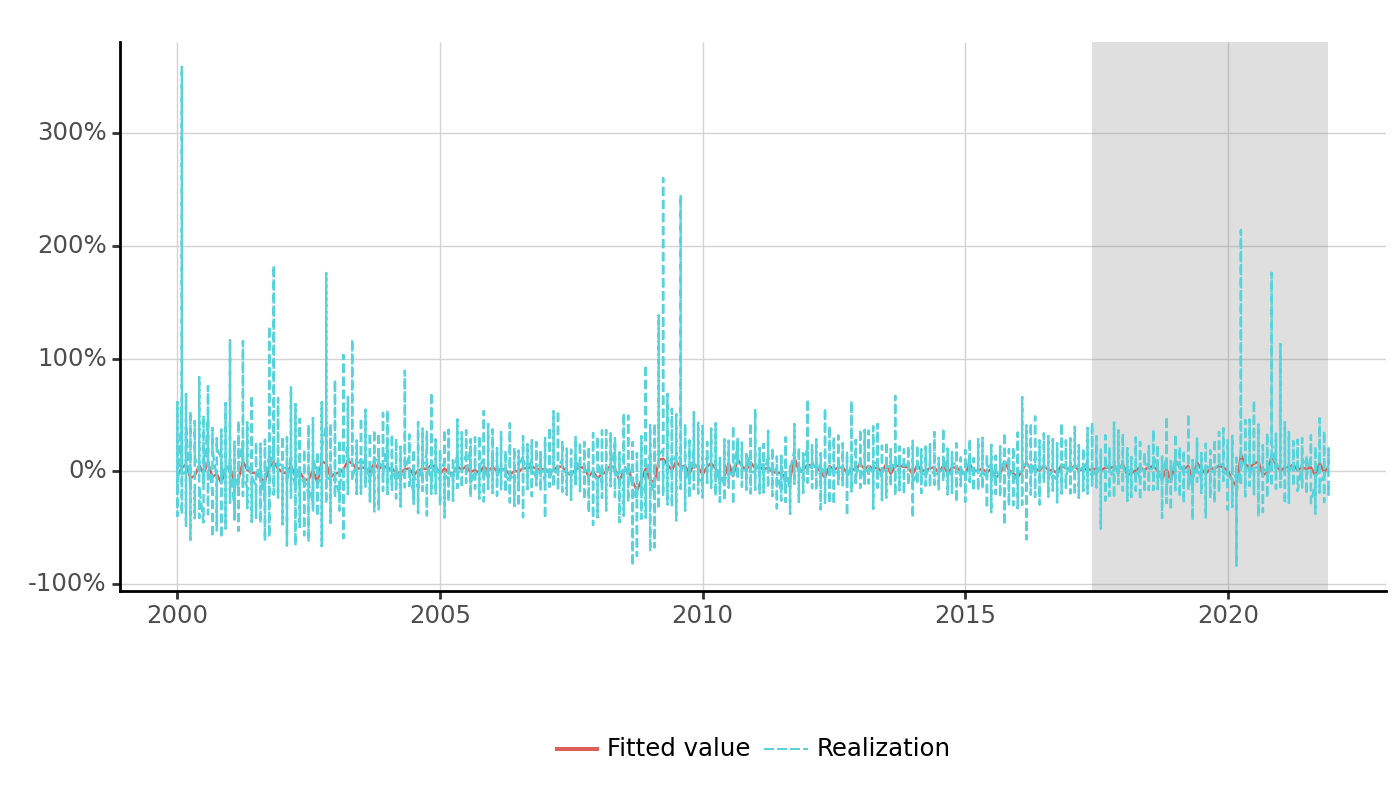

<Figure Size: (700 x 400)>

In [59]:
POLS(predicted_values_capm)

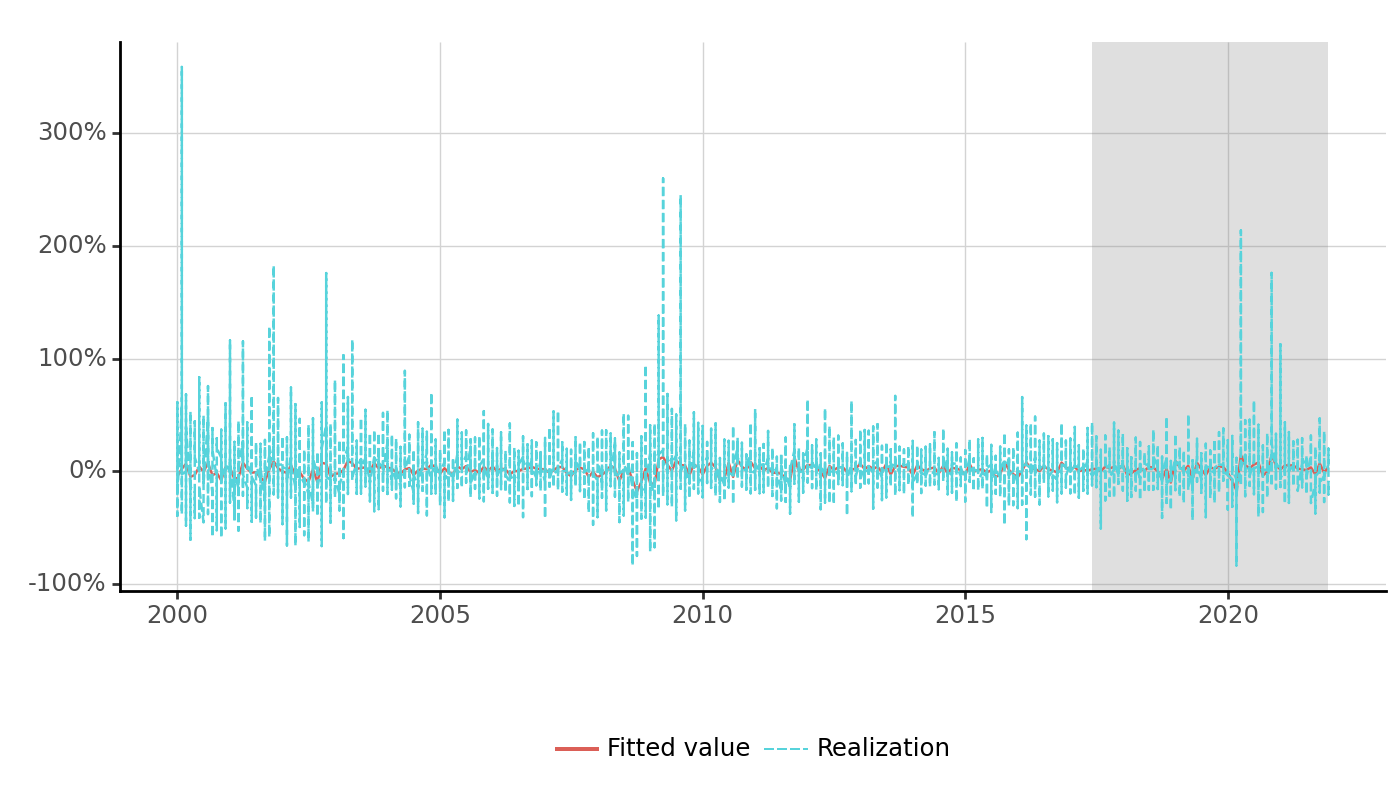

<Figure Size: (700 x 400)>

In [60]:
POLS(predicted_values_ff3)

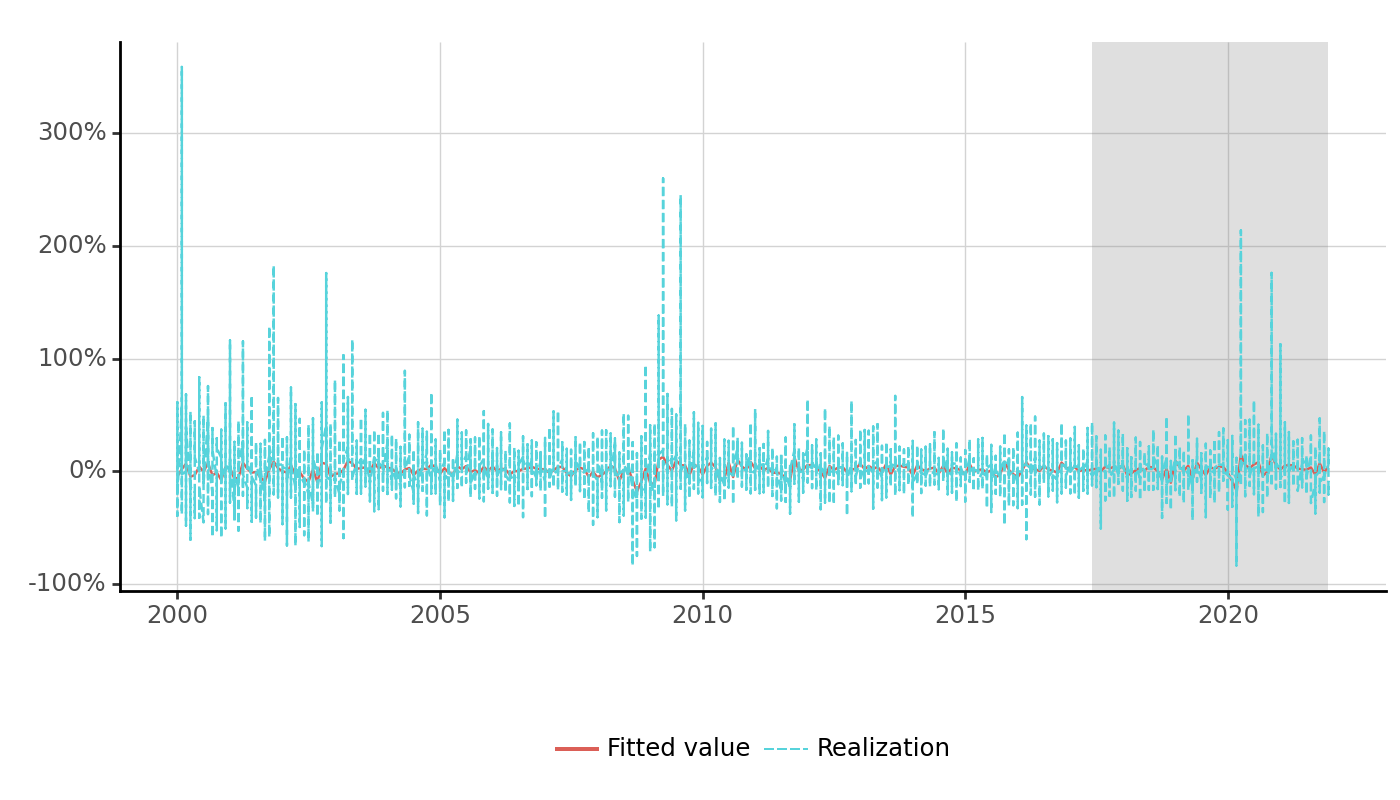

<Figure Size: (700 x 400)>

In [61]:
POLS(predicted_values_ff5)

### Regularization

In [212]:
# Select amount of tickers in cross section!
data_total = (crsp_50
        .merge(factors_ff5_monthly,
               how = "left", left_on = "month", right_on = "factor_ff5_month")
        .assign(ret_excess=lambda x: x["ret"] - x["factor_ff5_rf"]) 
        .drop(columns=['ret', 'factor_ff5_month'])
        .dropna()
       )

# Make a dataframe for stock characteristics and factors
macro_variables = data_total.filter(like="macro").columns
factor_variables = data_total.filter(like="jkp_factor").columns
macro_factors = data_total[macro_variables]
factors = data_total[macro_variables].merge(data_total[factor_variables], left_index=True, right_index=True)
char = data_total[['mktcap', 'mktcap_lag_1', 'mktcap_lag_3', 'mktcap_lag_6', 'mktcap_lag_12', 'mom_1', 'mom_3','mom_6', 'mom_12']]
# List of tickers
tickers = data_total['ticker'].unique()

# Transform data
column_combinations = list(product(macro_factors, char)) 

new_column_values = []
for macro_column, char in column_combinations:
    new_column_values.append(data_total[macro_column] * data_total[char])

column_names = [" x ".join(t) for t in column_combinations]
new_columns = pd.DataFrame(dict(zip(column_names, new_column_values)))

# New data set with added combinations
data = pd.concat([data_total, new_columns], axis=1)

In [217]:
# FF 5 factor model
data_ff5 = data[['month','ticker','ret_excess','factor_ff5_mkt_excess','factor_ff5_smb','factor_ff5_hml','factor_ff5_rmw','factor_ff5_cma']]
colnames = ['month','ticker','ret_excess','mkt_excess','smb','hml','rmw','cma']
data_ff5.columns=colnames
data_ff5 = data_ff5.iloc[:,:8]
data_ff3 = data_ff5.iloc[:,:6]
data_capm = data_ff5.iloc[:,:4]

In [218]:
def preprocess(data):
    preprocessor = ColumnTransformer(
      transformers=[
        ("scale", StandardScaler(), 
        [col for col in data.columns 
          if col not in ["ret_excess", "month", "ticker"]])
      ],
      remainder="drop",
      verbose_feature_names_out=False
    )
    return preprocessor

In [219]:
preprocessor_capm = preprocess(data_capm)
preprocessor_ff3 = preprocess(data_ff3)
preprocessor_ff5 = preprocess(data_ff5)

In [235]:
def EN(data, preprocessor, l1_ratio):
    lm_model = ElasticNet(
      alpha=0.007,
      l1_ratio=l1_ratio, 
      max_iter=5000, 
      fit_intercept=False
    )  
    
    lm_pipeline = Pipeline([
      ("preprocessor", preprocessor),
      ("regressor", lm_model)
    ])
    
    training_date = "2017-07-01"
    data_training = (data.query(f"month<'{training_date}'"))
    
    lm_fit = lm_pipeline.fit(
      data_training, 
      data_training.get("ret_excess")
    )
    predicted_values = (pd.DataFrame({
        "Fitted value": lm_fit.predict(data),
        "Realization": data.get("ret_excess")
      })
      .assign(month = data["month"])
      .melt(id_vars="month", var_name="Variable", value_name="return")
    )
    alphas = np.logspace(-6, 6, 100)
    params = {
      "regressor__alpha": alphas}
    
    finder = GridSearchCV(
      lm_pipeline,
      param_grid=params,
      scoring="neg_root_mean_squared_error",
      cv=5
    )
    
    finder = finder.fit(
      data.drop(columns = ['ret_excess']), data.get("ret_excess")
    )
    selected_factors = pd.DataFrame(finder.best_estimator_.named_steps.regressor.coef_ != 0)
    optimal_alpha= finder.best_params_['regressor__alpha']  # Extract optimal alpha
    print(f'Optimal alpha: {optimal_alpha}')
    lm_model_trained = ElasticNet(
      alpha=optimal_alpha,
      l1_ratio=l1_ratio, 
      max_iter=5000, 
      fit_intercept=False
    ) 
    predicted_values = pd.DataFrame({
        "Fitted value": lm_fit.predict(data),
        "Realization": data.get("ret_excess")
    }).assign(month=data["month"]).melt(id_vars="month", var_name="Variable", value_name="return")
    # Compute out-of-sample R^2
    y_true = data['ret_excess']
    y_pred = lm_fit.predict(data.drop('ret_excess', axis=1))
    r2_oos = r2_score(y_true, y_pred)
    if l1_ratio==1:
        print(f"Lasso: Out-of-sample R^2: {round(r2_oos,8)}")
    else: 
        print(f"Elastic Net: Out-of-sample R^2: {round(r2_oos,8)}")

In [230]:
def ridge(data, preprocessor):
    lm_model = Ridge(alpha=0.007, max_iter=5000, fit_intercept=False)
 
    lm_pipeline = Pipeline([
      ("preprocessor", preprocessor),
      ("regressor", lm_model)
    ])
    
    training_date = "2017-07-01"
    data_training = (data.query(f"month<'{training_date}'"))
    
    lm_fit = lm_pipeline.fit(
      data_training, 
      data_training.get("ret_excess")
    )
    predicted_values = (pd.DataFrame({
        "Fitted value": lm_fit.predict(data),
        "Realization": data.get("ret_excess")
      })
      .assign(month = data["month"])
      .melt(id_vars="month", var_name="Variable", value_name="return")
    )
    alphas = np.logspace(-6, 6, 100)
    params = {
      "regressor__alpha": alphas}
    
    finder = GridSearchCV(
      lm_pipeline,
      param_grid=params,
      scoring="neg_root_mean_squared_error",
      cv=5
    )
    
    finder = finder.fit(
      data.drop(columns = ['ret_excess']), data.get("ret_excess")
    )
    selected_factors = pd.DataFrame(finder.best_estimator_.named_steps.regressor.coef_ != 0)
    optimal_alpha= finder.best_params_['regressor__alpha']  # Extract optimal alpha
    print(f'Optimal alpha: {optimal_alpha}')

    lm_model_trained = Ridge(
      alpha=optimal_alpha,
      max_iter=5000, 
      fit_intercept=False
    ) 
    predicted_values = pd.DataFrame({
        "Fitted value": lm_fit.predict(data),
        "Realization": data.get("ret_excess")
    }).assign(month=data["month"]).melt(id_vars="month", var_name="Variable", value_name="return")
    # Compute out-of-sample R^2
    y_true = data['ret_excess']
    y_pred = lm_fit.predict(data.drop('ret_excess', axis=1))
    r2_oos = r2_score(y_true, y_pred)
    print(f"Ridge: Out-of-sample R^2: {round(r2_oos,8)}")

In [236]:
opt_lasso_alpha = EN(data_ff3, preprocessor_ff3, l1_ratio=1)
opt_lasso_alpha = EN(data_ff5, preprocessor_ff5, l1_ratio=1)

Optimal alpha: 2.310129700083158e-06
Lasso: Out-of-sample R^2: 0.2423029
Optimal alpha: 0.00026560877829466864
Lasso: Out-of-sample R^2: 0.2423029


In [232]:
opt_ridge_alpha = ridge(data_ff5, preprocessor_ff5)

Optimal alpha: 231.01297000831582
Ridge: Out-of-sample R^2: 0.24989816


In [233]:
opt_en_alpha = EN(data_ff3, preprocessor_ff3, l1_ratio=0.5)
opt_en_alpha = EN(data_ff5, preprocessor_ff5, l1_ratio=0.5)

Optimal alpha: 2.1544346900318867e-05
Elastic Net: Out-of-sample R^2: 0.24611096
Optimal alpha: 0.0004641588833612782
Elastic Net: Out-of-sample R^2: 0.24611096


### RF

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import PolynomialFeatures

In [246]:
# FF 5 factor model
data_ff5 = data[['month','ticker','ret_excess','factor_ff5_mkt_excess','factor_ff5_smb','factor_ff5_hml','factor_ff5_rmw','factor_ff5_cma']]
colnames = ['month','ticker','ret_excess','mkt_excess','smb','hml','rmw','cma']
data_ff5.columns=colnames
# FF 3 factor model
data_ff3 = data_ff5.iloc[:,:6]
# ff3
data_capm = data_ff3.iloc[:,:4]

In [247]:
# For CAPM Factor Model (data_ff5)
df_capm = data_capm.copy()
df_capm.set_index('month', inplace=True)
y_capm = df_capm['ret_excess']
X_capm = df_capm.drop(columns=['ret_excess', 'ticker'])

# For FF 3 Factor Model (data_ff3)
df_ff3 = data_ff3.copy()
df_ff3.set_index('month', inplace=True)
y_ff3 = df_ff3['ret_excess']
X_ff3 = df_ff3.drop(columns=['ret_excess', 'ticker'])

# For FF 5 Factor Model (data_ff5)
df_ff5 = data_ff5.copy()
df_ff5.set_index('month', inplace=True)
y_ff5 = df_ff5['ret_excess']
X_ff5 = df_ff5.drop(columns=['ret_excess', 'ticker'])

def preprocess_data(X, y):
    training_date = "2017-07-01"
    poly = PolynomialFeatures(degree=2)
    scaler = StandardScaler()
    X_scaled_array = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled_array, index=X.index, columns=X.columns)
    X_poly = poly.fit_transform(X_scaled)


    # Splitting data into training and testing sets
    X_train = X_poly[X.index < training_date]
    X_test = X_poly[X.index >= training_date]
    y_train = y[y.index < training_date]
    y_test = y[y.index >= training_date]

    return X_train, X_test, y_train, y_test
    

X_train_capm, X_test_capm, y_train_capm, y_test_capm = preprocess_data(X_capm, y_capm)
X_train_ff3, X_test_ff3, y_train_ff3, y_test_ff3 = preprocess_data(X_ff3, y_ff3)
X_train_ff5, X_test_ff5, y_train_ff5, y_test_ff5 = preprocess_data(X_ff5, y_ff5)

In [248]:
# capm
num_estimators = [10, 25, 50]
# Create an empty dictionary to store the models
models_capm = {}
predictions_capm = {}

# Loop through the numbers of estimators
for n in num_estimators:
    start = time.time()

    # Define and train the Random Forest model
    model = RandomForestRegressor(n_estimators=n, random_state=42)
    model.fit(X_train_capm, y_train_capm)
    end = time.time()
    print(f'model_{n}: {round((end - start)/60,3)} minutes')

    # Store the trained model in the dictionary
    models_capm[f'model_{n}'] = model
print('------------------')
evaluation_results = {}

# Loop through the models
for model_name, model in models_capm.items():
    # Evaluate the model
    y_pred_capm = model.predict(X_test_capm)
    mse = mean_squared_error(y_test_capm, y_pred_capm)
    r2_capm = r2_score(y_test_capm, y_pred_capm)
    
    # Store the evaluation results in the dictionary
    evaluation_results[model_name] = {'Mean Squared Error': mse, 'R^2 Score': r2_capm}
# Print the evaluation results
for model_name, results in evaluation_results.items():
    print(f"capm Evaluation results for {model_name}:")
    print("Mean Squared Error:", round(results['Mean Squared Error'],4))
    print("R^2 Score:", round(results['R^2 Score'],4))
    print()

model_10: 0.003 minutes
model_25: 0.002 minutes
model_50: 0.004 minutes
------------------
capm Evaluation results for model_10:
Mean Squared Error: 0.0042
R^2 Score: 0.3166

capm Evaluation results for model_25:
Mean Squared Error: 0.0042
R^2 Score: 0.3173

capm Evaluation results for model_50:
Mean Squared Error: 0.0042
R^2 Score: 0.3178



In [249]:
# ff3
num_estimators = [10, 25, 50]

# Create an empty dictionary to store the models
models_ff3 = {}
predictions_ff3 = {}

# Loop through the numbers of estimators
for n in num_estimators:
    start = time.time()

    # Define and train the Random Forest model
    model = RandomForestRegressor(n_estimators=n, random_state=42)
    model.fit(X_train_ff3, y_train_ff3)
    end = time.time()
    print(f'model_{n}: {round((end - start)/60,3)} minutes')

    # Store the trained model in the dictionary
    models_ff3[f'model_{n}'] = model
print('------------------')
evaluation_results = {}

# Loop through the models
for model_name, model in models_ff3.items():
    # Evaluate the model
    y_pred_ff3 = model.predict(X_test_ff3)
    mse = mean_squared_error(y_test_ff3, y_pred_ff3)
    r2_ff3 = r2_score(y_test_ff3, y_pred_ff3)
    
    # Store the evaluation results in the dictionary
    evaluation_results[model_name] = {'Mean Squared Error': mse, 'R^2 Score': r2_ff3}
# Print the evaluation results
for model_name, results in evaluation_results.items():
    print(f"ff3 Evaluation results for {model_name}:")
    print("R^2 Score:", round(results['R^2 Score'],4))
    print()



model_10: 0.002 minutes
model_25: 0.005 minutes
model_50: 0.01 minutes
------------------
ff3 Evaluation results for model_10:
R^2 Score: 0.3166

ff3 Evaluation results for model_25:
R^2 Score: 0.3123

ff3 Evaluation results for model_50:
R^2 Score: 0.3181



In [87]:
# ff5
num_estimators =  [100, 150, 200]

# Create an empty dictionary to store the models
models_ff5 = {}
predictions_ff5 = {}

# Loop through the numbers of estimators
for n in num_estimators:
    start = time.time()

    # Define and train the Random Forest model
    model = RandomForestRegressor(n_estimators=n, random_state=42)
    model.fit(X_train_ff5, y_train_ff5)
    end = time.time()
    print(f'model_{n}: {round((end - start)/60,3)} minutes')

    # Store the trained model in the dictionary
    models_ff5[f'model_{n}'] = model
print('------------------')
evaluation_results = {}

# Loop through the models
for model_name, model in models_ff5.items():
    # Evaluate the model
    y_pred_ff5 = model.predict(X_test_ff5)
    mse = mean_squared_error(y_test_ff5, y_pred_ff5)
    r2_ff5 = r2_score(y_test_ff5, y_pred_ff5)
    
    # Store the evaluation results in the dictionary
    evaluation_results[model_name] = {'Mean Squared Error': mse, 'R^2 Score': r2_ff5}
# Print the evaluation results
for model_name, results in evaluation_results.items():
    print(f"ff5 Evaluation results for {model_name}:")
    print("Mean Squared Error:", round(results['Mean Squared Error'],4))
    print("R^2 Score:", round(results['R^2 Score'],4))
    print()



model_100: 0.709 minutes
model_150: 1.028 minutes
model_200: 1.368 minutes
------------------
ff5 Evaluation results for model_100:
Mean Squared Error: 0.0115
R^2 Score: 0.2169

ff5 Evaluation results for model_150:
Mean Squared Error: 0.0115
R^2 Score: 0.2176

ff5 Evaluation results for model_200:
Mean Squared Error: 0.0115
R^2 Score: 0.2177



# For later

### NN

In [253]:
# FF 5 factor model
data_ff5 = data[['month','ticker','ret_excess','factor_ff5_mkt_excess','factor_ff5_smb','factor_ff5_hml','factor_ff5_rmw','factor_ff5_cma']]
colnames = ['month','ticker','ret_excess','mkt_excess','smb','hml','rmw','cma']
data_ff5.columns=colnames
# FF 3 factor model
data_ff3 = data_ff5.iloc[:,:6]
# ff3
data_capm = data_ff3.iloc[:,:4]
# FF 5 factor model
data_ff5 = data[['month','ticker','ret_excess','factor_ff5_mkt_excess','factor_ff5_smb','factor_ff5_hml','factor_ff5_rmw','factor_ff5_cma']]
colnames = ['month','ticker','ret_excess','mkt_excess','smb','hml','rmw','cma']
data_ff5.columns=colnames
# FF 3 factor model
data_ff3 = data_ff5.iloc[:,:6]
# ff3
data_capm = data_ff3.iloc[:,:4]

# For FF 5 Factor Model (data_ff5)
df_capm = data_capm.copy()
df_capm.set_index('month', inplace=True)
y_capm = df_capm['ret_excess']
X_capm = df_capm.drop(columns=['ret_excess', 'ticker'])

# For FF 3 Factor Model (data_ff3)
df_ff3 = data_ff3.copy()
df_ff3.set_index('month', inplace=True)
y_ff3 = df_ff3['ret_excess']
X_ff3 = df_ff3.drop(columns=['ret_excess', 'ticker'])

# For ff3 (data_ff3)
df_ff5 = data_ff3.copy()
df_ff5.set_index('month', inplace=True)
y_ff5 = df_ff3['ret_excess']
X_ff5 = df_ff3.drop(columns=['ret_excess', 'ticker'])
X_train_capm, X_test_capm, y_train_capm, y_test_capm = preprocess_data(X_capm, y_capm)
X_train_ff3, X_test_ff3, y_train_ff3, y_test_ff3 = preprocess_data(X_ff3, y_ff3)
X_train_ff5, X_test_ff5, y_train_ff5, y_test_ff5 = preprocess_data(X_ff5, y_ff5)

In [271]:
def create_neural_network(layers, neurons, n_features):
    model = keras.Sequential()
    model.add(keras.layers.Dense(neurons[0], activation='sigmoid', input_shape=(n_features,), name='input_layer'))
    
    for i in range(layers):
        model.add(keras.layers.Dense(neurons[i], activation='sigmoid', name=f'hidden_layer_{i+1}'))
    
    model.add(keras.layers.Dense(1, name='output_layer'))  # Output layer
    
    return model

In [368]:
n_features_capm = X_train_capm.shape[1]
n_features_ff3 = X_train_ff3.shape[1]
n_features_ff5 = X_train_ff5.shape[1]

In [369]:
#CAPM
model_1_capm = create_neural_network(1, [2], n_features_capm)
model_1_capm.compile(optimizer='adam', loss='mean_squared_error')

model_2_capm = create_neural_network(2, [2,2,1], n_features_capm)
model_2_capm.compile(optimizer='adam', loss='mean_squared_error')

model_3_capm = create_neural_network(3, [2,2,1], n_features_capm)
model_3_capm.compile(optimizer='adam', loss='mean_squared_error')
#FF3
model_1_ff3 = create_neural_network(1, [2], n_features_capm)
model_1_ff3.compile(optimizer='adam', loss='mean_squared_error')

model_2_ff3 = create_neural_network(2, [2,2,1], n_features_capm)
model_2_ff3.compile(optimizer='adam', loss='mean_squared_error')

model_3_ff3 = create_neural_network(3, [2,2,1], n_features_capm)
model_3_ff3.compile(optimizer='adam', loss='mean_squared_error')
#FF5
model_1_ff5 = create_neural_network(1, [2], n_features_capm)
model_1_ff5.compile(optimizer='adam', loss='mean_squared_error')

model_2_ff5 = create_neural_network(2, [2,2,1], n_features_capm)
model_2_ff5.compile(optimizer='adam', loss='mean_squared_error')

model_3_ff5 = create_neural_network(3, [2,2,1], n_features_capm)
model_3_ff5.compile(optimizer='adam', loss='mean_squared_error')

In [274]:
#CAPM
model_4_capm = create_neural_network(4, [2,2,2,1], n_features_capm)
model_4_capm.compile(optimizer='adam', loss='mean_squared_error')

model_5_capm = create_neural_network(5, [2,2,2,2,1], n_features_capm)
model_5_capm.compile(optimizer='adam', loss='mean_squared_error')

model_6_capm = create_neural_network(5, [2,2,2,2,2,1], n_features_capm)
model_6_capm.compile(optimizer='adam', loss='mean_squared_error')
#FF3
model_4_ff3 = create_neural_network(4, [2,2,2,1], n_features_ff3)
model_4_ff3.compile(optimizer='adam', loss='mean_squared_error')

model_5_ff3 = create_neural_network(5, [2,2,2,2,1], n_features_ff3)
model_5_ff3.compile(optimizer='adam', loss='mean_squared_error')

model_6_ff3 = create_neural_network(5, [2,2,2,2,2,1], n_features_ff3)
model_6_ff3.compile(optimizer='adam', loss='mean_squared_error')
#FF5
model_4_ff5 = create_neural_network(4, [2,2,2,1], n_features_ff5)
model_4_ff5.compile(optimizer='adam', loss='mean_squared_error')

model_5_ff5 = create_neural_network(5, [2,2,2,2,1], n_features_ff5)
model_5_ff5.compile(optimizer='adam', loss='mean_squared_error')

model_6_ff5 = create_neural_network(5, [2,2,2,2,2,1], n_features_ff5)
model_6_ff5.compile(optimizer='adam', loss='mean_squared_error')

In [372]:
def NN(model, X_train, y_train, X_test, y_test):
    start = time.time()
    history = model.fit(X_train, y_train, epochs=50, verbose = 0,  batch_size=32, validation_split=0.2)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Calculate R^2 score and MSPE
    r2 = r2_score(y_test, y_pred)
    mspe = mean_squared_error(y_test, y_pred)
    print(" Out-of-sample R^2:", round(r2,4))
    #print("Mean Squared Prediction Error (MSPE):", round(mspe,4))
    
    end = time.time()
    print(f'{round(end - start,3)/60} minutes')
models_capm = [model_1_capm,model_2_capm,model_3_capm]
#models_ff3 = [model_1_ff3,model_2_ff3,model_3_ff3]
#models_ff5 = [model_1_ff5,model_2_ff5,model_3_ff5]
#models_capm = [model_4_capm,model_5_capm,model_6_capm]
#models_ff3 = [model_4_ff3,model_5_ff3,model_6_ff3]
#models_ff5 = [model_4_ff5,model_5_ff5,model_6_ff5]

In [ ]:
# capm
for model in models_capm:
    NN(model, X_train_capm, y_train_capm, X_test_capm, y_test_capm)

In [ ]:
# FF3
for model in models_ff3:
    NN(model, X_train_ff3, y_train_ff3, X_test_ff3, y_test_ff3)

In [ ]:
# ff5
for model in models_ff5:
    NN(model, X_train_ff5, y_train_ff5, X_test_ff5, y_test_ff5)

### LTSM

In [ ]:
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

def create_neural_network(layers, neurons, n_features):
    model = keras.Sequential()
    model.add(keras.layers.LSTM(neurons[0], activation='relu', input_shape=(1, n_features), return_sequences=True, name='input_layer'))
    
    for i in range(1, layers):
        model.add(keras.layers.LSTM(neurons[i], activation='relu', return_sequences=True, name=f'hidden_layer_{i}'))
    
    model.add(keras.layers.LSTM(neurons[-1], activation='relu', name=f'hidden_layer_{layers}'))  # Last LSTM layer without return_sequences
    
    model.add(keras.layers.Dense(1, name='output_layer'))  # Output layer
    
    return model

In [387]:
X_train_ff5_reshaped = np.reshape(X_train_ff5, (X_train_ff5.shape[0], 1, X_train_ff5.shape[1]))
X_test_ff5_reshaped = np.reshape(X_test_ff5, (X_test_ff5.shape[0], 1, X_test_ff5.shape[1]))
n_features_ff5 = X_train_ff5.shape[1]

In [ ]:
model_4 = create_neural_network(4, [2,2,2,1], n_features_ff5)
model_4.compile(optimizer='adam', loss='mean_squared_error')

model_5 = create_neural_network(5, [2,2,2,2,1], n_features_ff5)
model_5.compile(optimizer='adam', loss='mean_squared_error')

model_6 = create_neural_network(6, [2,2,2,2,2,1], n_features_ff5)
model_6.compile(optimizer='adam', loss='mean_squared_error')
def NN(model, X_train, y_train, X_test, y_test):
    start = time.time()
    history = model.fit(X_train, y_train, epochs=50, verbose = 0,  batch_size=32, validation_split=0.2)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Calculate R^2 score and MSPE
    r2 = r2_score(y_test, y_pred)
    mspe = mean_squared_error(y_test, y_pred)
    print(" Out-of-sample R^2:", round(r2,4))
    print("Mean Squared Prediction Error (MSPE):", round(mspe,4))
    
    end = time.time()
    print(f'{round(end - start,3)/60} minutes')
    
models = [model_4,model_5,model_6]
for model in models:
    NN(model, X_train_ff5_reshaped, y_train_ff5, X_test_ff5_reshaped, y_test_ff5)